# 1

In [2]:
import numpy as np
import cvxpy as cp
from data.quad_metric_data import n, N, N_test, X, Y, X_test, Y_test, d, d_test

P = cp.Variable((n, n), PSD=True)
X_minus_Y = X - Y
#d2 = (X_minus_Y.T @ (P @ X_minus_Y))[np.diag_indices(N)]
d2 = []
for i in range(N):
    d2.append(cp.quad_form(X_minus_Y[:,i], P))
d2 = cp.hstack(d2)
obj = cp.Minimize((cp.sum(d**2 + d2) - 2 * d @ cp.sqrt(d2)) / N)
problem = cp.Problem(obj, [])
problem.solve()
print(f'Problem status: {problem.status}')
print(f'Optimal distance: {problem.value}')
our_P = P.value
X_minus_Y_test = X_test - Y_test
d_test_hat = np.sqrt(((X_minus_Y_test.T).dot(our_P).dot(X_minus_Y_test))[np.diag_indices(N_test)])
test_error = np.mean((d_test_hat - d_test)**2)
print(f'test_error: {test_error}')


Problem status: optimal
Optimal distance: 0.8464401671710604
test_error: 0.8235344471677613


# 2

Experiment positive. status: optimal
Optimal objective: 57.613982
Experiment relaxed. status: optimal
Optimal objective: 0.000000


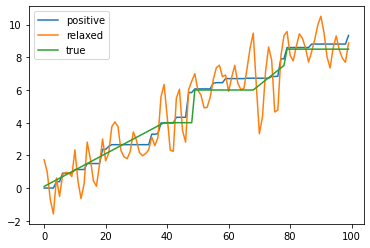

In [4]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from data.ml_estim_incr_signal_data import N, k, h, y
y = np.asarray(y)

expermient_names = ['positive', 'relaxed']
x_values = dict()
for name in expermient_names:
    x = cp.Variable(N)
    yhat = cp.conv(h, x)[:N]
    error = (yhat - y)**2
    obj = cp.Minimize(cp.sum(error))
    if name == 'positive':
        constraints = [
                x[0] >= 0,
                x[1:] >= x[:-1],
                ]
    else:
        constraints = []

    problem = cp.Problem(obj, constraints)
    problem.solve()
    print(f'Experiment {name}. status: {problem.status}')
    print(f'Optimal objective: {problem.value:.6f}')
    x_values[name] = x.value

from data.ml_estim_incr_signal_data import xtrue
xtrue = np.asarray(xtrue)
x_values['true'] = xtrue
fig, ax = plt.subplots()
for name, val in x_values.items():
    ax.plot(np.arange(N), val, label=name)
ax.legend()
plt.show()


# 3

In [5]:
import numpy as np
import cvxpy as cp
from data.blend_design_data import n, k, W, W_min, W_max, P, D, A, P_spec, D_spec, A_spec
np.set_printoptions(precision=6, suppress=True)

#fixing the data
W = np.asarray(W)
A = np.asarray(A)
P = np.asarray(P)
D = np.asarray(D)

lb = cp.Variable(k) #lb is short for lambda
data = [
        (A, A_spec),
        (P, P_spec),
        (D, D_spec),
        ]
constraints = [np.log(F) @ lb <= np.log(F_spec) for (F, F_spec) in data]
constraints += [
        lb >= 0,
        cp.sum(lb) == 1,
        ]
obj = cp.Minimize(0)
problem = cp.Problem(obj, constraints)
problem.solve()
print(f'Problem status: {problem.status}')
print(f'optim lb: {lb.value}')

V = np.log(W)
v = V @ lb.value
w = np.exp(v)
print(f'feasible w: {w}')


Problem status: optimal
optim lb: [0.017587 0.496738 0.004523 0.475314 0.00409  0.001748]
feasible w: [2.638598 3.280692 2.96934  3.266178 2.324269 3.66533  2.929761 3.685718
 3.89403  3.397201]


# 5

problem status: optimal
Relative recovery error = 0.12083181575639237
Short sentence: The recovery is good I guess :))


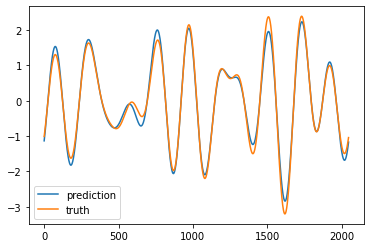

In [6]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from data.zero_crossings_data import n, f_min, B, s

C = np.cos(2 * np.pi / n * np.outer(np.arange(n) + 1, f_min + np.arange(B)))
D = np.sin(2 * np.pi / n * np.outer(np.arange(n) + 1, f_min + np.arange(B)))

a = cp.Variable(B)
b = cp.Variable(B)
y_hat = cp.Variable(n)
constraints = [
        C @ a + D @ b == y_hat,
        s @ y_hat == n,
        cp.multiply(s, y_hat) >= 0,
        ]
obj = cp.Minimize(cp.norm(y_hat))
problem = cp.Problem(obj, constraints)
problem.solve()
print(f'problem status: {problem.status}')

from data.zero_crossings_data import y
relative_recovery_error = np.linalg.norm(y_hat.value - y) / np.linalg.norm(y)
print(f'Relative recovery error = {relative_recovery_error}')
print("Short sentence: The recovery is good I guess :))")

fig, ax = plt.subplots()
ax.plot(np.arange(n), y_hat.value, label='prediction')
ax.plot(np.arange(n), y, label='truth')
ax.legend()
plt.show()
